#  Use SARIMAX to model the time series process 

# Define global variable(train_end, predict_start, predict_end) and common functions

Define train and predict windows 

In [22]:
# for development 
# train_end='2019-6'
# predict_start='2019-7'
# predict_end='2019-9'

# for final submit 
train_end='2019-9'
predict_start='2019-10'
predict_end='2019-12'

## Auto_arima Function
note the d is default at  0 and trace =True. Can turn it off or change

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [24]:
import pmdarima as pm 
def auto_arima(df,col_exog,d=0):
    try:
        results=pm.auto_arima(df[['stock_distributed']],
                              exog=df[col_exog],
                              seasonal=True,information_criterion='bic',m=12,
                          d=d, D=0, 
                          max_p=4, max_q=4, 
                          trace=True, # can turn Trace off 
                          error_action='ignore',
                          suppress_warnings=True)
        print(results.order)
        print(results.seasonal_order)
        #print(col_exog)
        return[results.order,results.seasonal_order] 
    except:
        print('error searching')

## SARIMAX - Region

It's region specific because the df_pred_agg_results_piece. The result collection part and the plot part assumes df is on regional level 

In [25]:

def predict_sarimax(df,order,seasonal_order,col_exog,plot=0):
    try:
        df_train=df[:train_end]
        df_test=df[predict_start:predict_end]
        model = SARIMAX(df_train['stock_distributed'], order=order,seasonal_order=seasonal_order,
                        exog=df_train[col_exog])
        result=model.fit()
        sarima_mean_insample=result.get_prediction(start=df_train.index[0],end=train_end,
                                                   exog=df_train[col_exog]).predicted_mean
        sarima_mean_outsample=result.get_prediction(start=predict_start,end=predict_end,
                                                    exog=df[predict_start:predict_end][col_exog]).predicted_mean
        sarima_mean_prediction=sarima_mean_insample.append(sarima_mean_outsample)
        district=df.iloc[0].district
        product_code=df.iloc[0].product_code
        
        df_pred_agg_results_piece=pd.DataFrame(data=sarima_mean_prediction,columns=['stock_distributed_forecasted'])
        df_pred_agg_results_piece['district']=district
        df_pred_agg_results_piece['product_code']=product_code 
        if plot==1:
            pd.DataFrame({'insample_pred':sarima_mean_insample,'outsample_pred':sarima_mean_outsample,'actual_value':df['stock_distributed']}).plot(); 
            plt.title(district+"--"+product_code)
            plt.show()
        return df_pred_agg_results_piece
    except:
        print('error')

# Import and process data 

## Import '../0_data/df_combined_fullsample.csv'

In [26]:
import pandas as pd
 #  contraceptive_logistics=pd.read_csv('../0_data/df_combined.csv') 
contraceptive_logistics=pd.read_csv('../0_data/df_combined_fullsample.csv')
contraceptive_logistics['day']=1
contraceptive_logistics['date']=pd.to_datetime(contraceptive_logistics[['year','month','day']])
contraceptive_logistics=contraceptive_logistics.sort_values('date')

## Aggregate on District level

In [27]:
col_continuous=['regionroads',
       'regionasphaltroads', 'regionearthroads', 'regionsurfacetreatmentroads',
       'regionpoorroads', 'poorroads', 'earthroads', 'asphaltroads',
       'site_type', 'product_type', 'temp', 'maxtemp', 'pressure',
       'relativehumidity', 'rainfallsnowmelt', 'visibility', 'windspeed',
       'maxsustainedwindspeed', 'rainordrizzle', 'storm', 'fog']
col_continuous.remove('site_type') # they are not continuous
col_continuous.remove('product_type') # they are not continuous

product_agg_level_sum=contraceptive_logistics.groupby(['district','product_code','date'])['stock_distributed'].sum()
df_product_agg_level_sum=pd.DataFrame(data=product_agg_level_sum)
df_product_agg_level_sum=df_product_agg_level_sum.reset_index()

for col in col_continuous:
    print(col)
    df_product_agg_level_sum[col]=pd.DataFrame(data=contraceptive_logistics.groupby(['district','product_code','date'])[col].mean().values)
    
    

regionroads
regionasphaltroads
regionearthroads
regionsurfacetreatmentroads
regionpoorroads
poorroads
earthroads
asphaltroads
temp
maxtemp
pressure
relativehumidity
rainfallsnowmelt
visibility
windspeed
maxsustainedwindspeed
rainordrizzle
storm
fog


# SARIMAX

- need to write this part 

In [28]:
col_exog=col_continuous

### Test on a few example 

AGBOVILLE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=239.923, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=244.506, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=244.329, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=253.235, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=242.213, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=242.086, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=242.984, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=243.030, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=244.876, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.920 seconds
(0, 0, 0)
(0, 0, 0, 12)


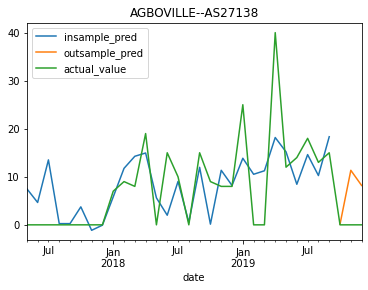

AGBOVILLE
AS27139
AGNIBILEKROU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=285.904, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=292.824, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=293.216, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=296.324, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=289.761, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=289.752, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=288.976, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=289.374, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=285.973, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.973 seconds
(0, 0, 0)
(0, 0, 0, 12)


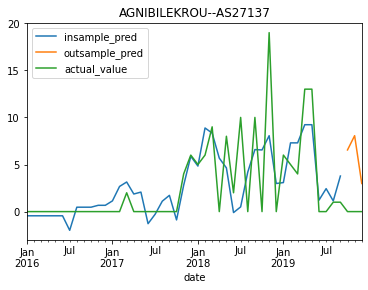

AGNIBILEKROU
AS27138


In [29]:
df_pred_district_product=pd.DataFrame()
for district in df_product_agg_level_sum['district'].unique()[6:8] :
    df1=df_product_agg_level_sum[df_product_agg_level_sum['district']==district];
    for product in df1['product_code'].unique()[6:8]:
        df2=df1[df1['product_code']==product].copy();
        df2['date']=pd.to_datetime(df2['date']);
        df2=df2.set_index(['date']);
        df2=df2.resample('MS').fillna('nearest')
        print(district)
        print(product)
        #fit_and_plot_forecast(df2)
        if(len(df2)>10):
            [order,seasonal_order]=auto_arima(df2,col_exog); 
            #result_piece= fit_and_plot_sarimax(df2,order,seasonal_order,col_exog);
            result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=1);
            # print(result_piece)
            df_pred_district_product=pd.concat([df_pred_district_product,result_piece])

## Run the full data df_product_agg_level_sum (district level) 

## Export '../2_pipeline/final_pred_district_lev.csv'

ABENGOUROU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=105.293, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=92.644, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=96.835, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=94.935, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=95.605, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=96.472, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=96.451, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=92.969, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=91.075, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=94.937, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=94.835, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=94.721, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[12] intercep

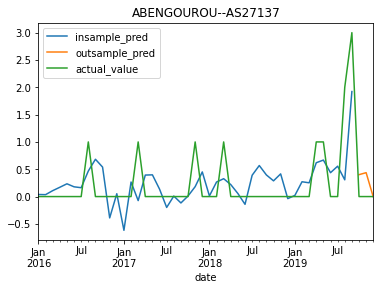

ABENGOUROU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=270.512, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=261.322, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=265.509, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=268.517, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=263.918, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=266.998, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=261.640, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=263.238, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=261.635, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.725 seconds
(0, 0, 0)
(0, 0, 0, 12)


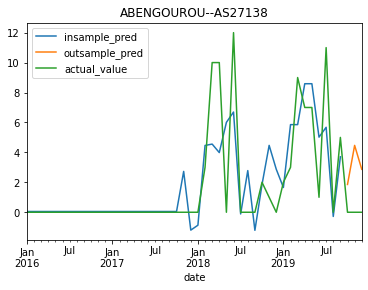

ABOBO-EST
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=407.428, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=412.467, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=412.590, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=444.087, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=409.329, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=409.499, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=412.898, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=409.608, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=409.795, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=413.458, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.103 seconds
(0, 0, 0)
(0, 0, 0, 12)


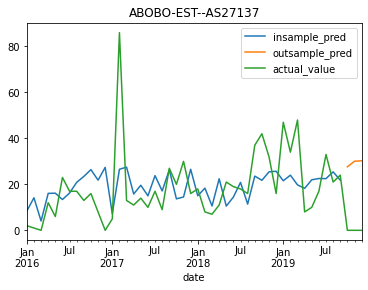

ABOBO-EST
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=488.862, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=487.008, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=487.852, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=510.485, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=483.156, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=487.012, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=490.753, Time=0.54 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=487.025, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=487.014, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=484.012, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=489.402, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=486.423, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.659 seconds
(1, 0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


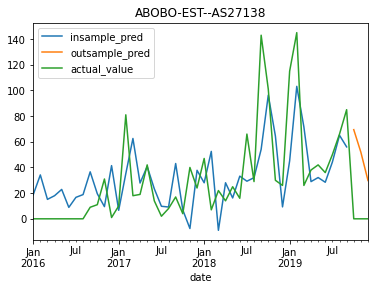

ABOISSO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=364.105, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=368.929, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=369.243, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=384.828, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=366.270, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=366.400, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=366.585, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=366.739, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=370.360, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.039 seconds
(0, 0, 0)
(0, 0, 0, 12)


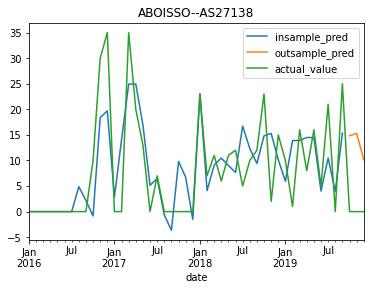

ABOISSO
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-957.643, Time=0.02 sec
Total fit time: 0.025 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


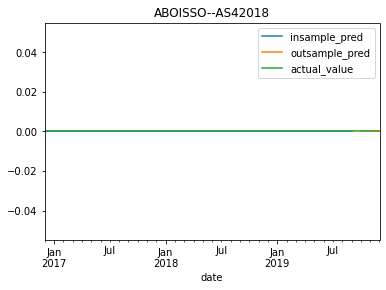

ADIAKE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=143.306, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=145.912, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=147.208, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=158.345, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=144.052, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=144.870, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=144.871, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=145.654, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=146.349, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.307 seconds
(0, 0, 0)
(0, 0, 0, 12)


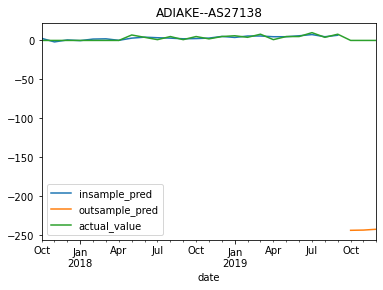

ADIAKE
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-879.788, Time=0.02 sec
Total fit time: 0.025 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


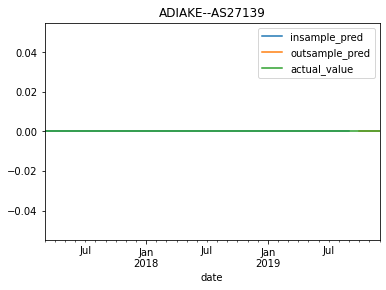

ADJAME-PLATEAU-ATTECOUBE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=475.508, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=478.448, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=477.676, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=499.716, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=477.076, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=474.731, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=477.142, Time=0.10 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=478.095, Time=0.36 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 3.117 seconds
(0, 0, 0

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


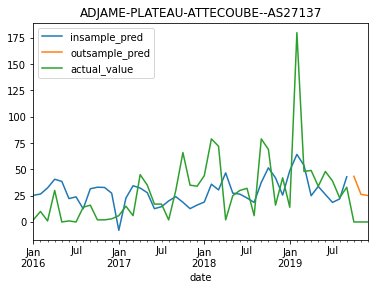

ADJAME-PLATEAU-ATTECOUBE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=530.038, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=515.087, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=526.198, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=554.446, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=511.430, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=515.004, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=518.455, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=508.522, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=512.157, Time=0.26 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=512.047, Time=0.16 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=511.533, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=511.808, Time=0.13 sec
 ARIMA(1,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


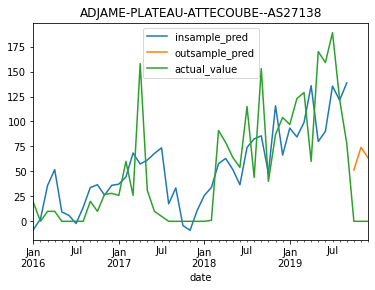

ADZOPE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=191.829, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=196.859, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=196.841, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=210.050, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=193.785, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=193.785, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=196.964, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=194.699, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=194.691, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=197.868, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.259 seconds
(0, 0, 0)
(0, 0, 0, 12)


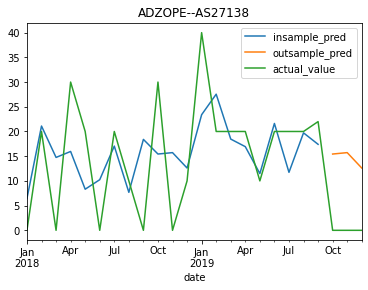

ADZOPE
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-646.277, Time=0.02 sec
Total fit time: 0.023 seconds
(0, 0, 0)
(0, 0, 0, 0)
error


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AGBOVILLE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=239.923, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=244.506, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=244.329, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=253.235, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=242.213, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=242.086, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=242.984, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=243.030, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=244.876, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.427 seconds
(0, 0, 0)
(0, 0, 0, 12)


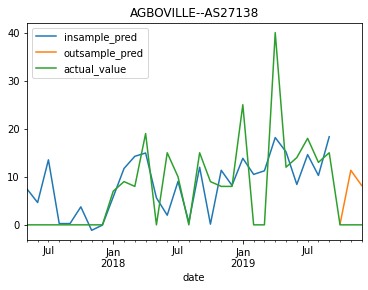

AGBOVILLE
AS27139
AGNIBILEKROU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=285.904, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=292.824, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=293.216, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=296.324, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=289.761, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=289.752, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=288.976, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=289.374, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=285.973, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.389 seconds
(0, 0, 0)
(0, 0, 0, 12)


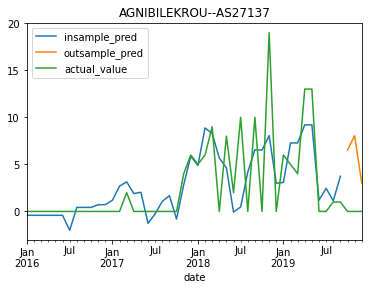

AGNIBILEKROU
AS27138
AKOUPE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=364.932, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=344.427, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=354.078, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=382.748, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=340.744, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=344.425, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=343.089, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=340.965, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=351.982, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=344.596, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=339.588, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=342.862, Time=0.07 sec
 ARIM

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


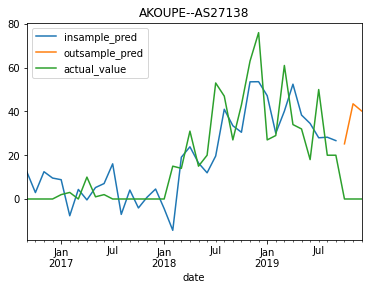

AKOUPE
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1165.286, Time=0.04 sec
Total fit time: 0.041 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


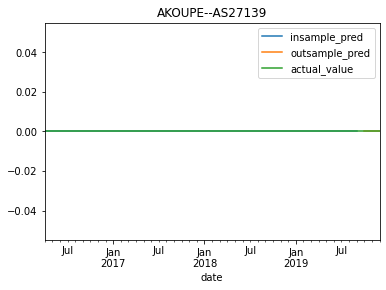

ALEPE
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1191.244, Time=0.03 sec
Total fit time: 0.031 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


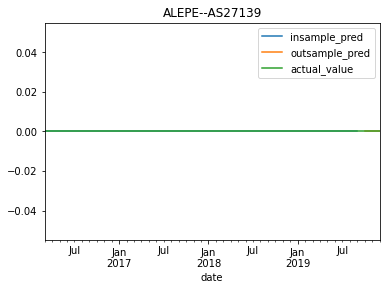

ALEPE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=511.851, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=495.580, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=501.372, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=501.829, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=531.797, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=498.631, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=498.859, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=502.064, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=498.237, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=498.519, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=501.483, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.455 seconds
(0, 0, 0)
(0, 0, 0, 12)


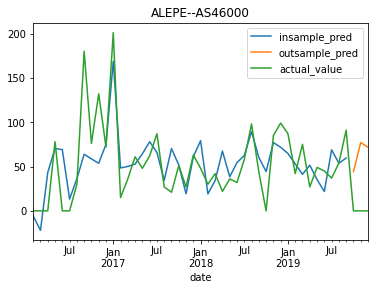

ANYAMA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=373.423, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=379.719, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=379.600, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=400.628, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=376.571, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=376.361, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=376.652, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=376.547, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=380.359, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.624 seconds
(0, 0, 0)
(0, 0, 0, 12)


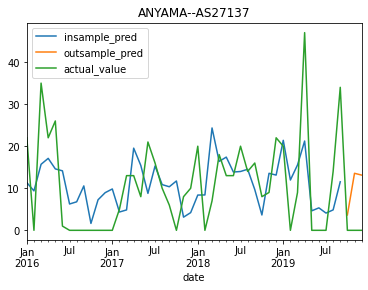

ANYAMA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=401.958, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=394.996, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=395.512, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=441.010, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=391.435, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=394.896, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=395.168, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=395.090, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=392.634, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=398.927, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=395.372, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.888 seconds
(1, 0, 0)
(0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


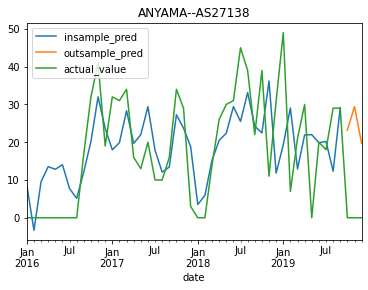

BANGOLO
AS42018
BANGOLO
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=457.874, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=461.916, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=460.938, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=457.945, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=461.028, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=461.030, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=464.454, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=459.004, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=458.288, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=461.662, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.971 seconds
(0, 0, 0)
(0, 0, 0, 12)


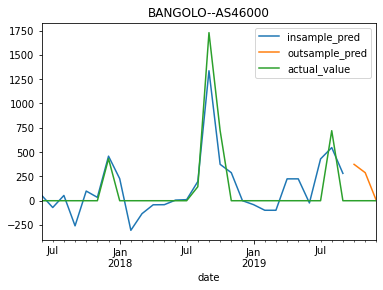

BEOUMI
AS42018
BETTIE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=75.466, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=61.790, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=64.945, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=64.275, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=64.275, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=66.760, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=64.038, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=63.965, Time=0.03 sec


C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.849 seconds
(0, 0, 0)
(0, 0, 0, 12)


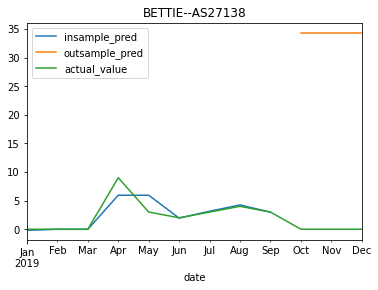

BETTIE
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-464.747, Time=0.02 sec
Total fit time: 0.025 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


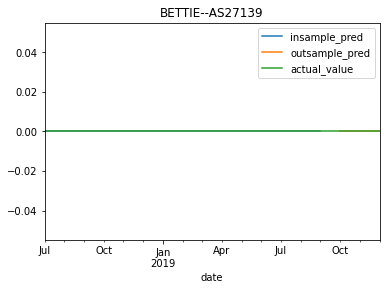

BIANKOUMA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=250.980, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=257.096, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=257.205, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=250.953, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=254.633, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=254.585, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=253.417, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=253.569, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=255.772, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.482 seconds
(0, 0, 0)
(0, 0, 0, 12)


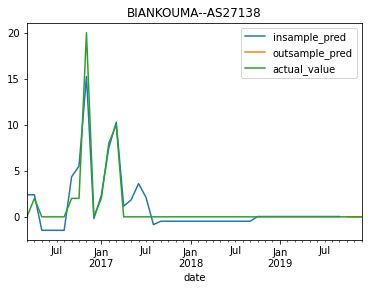

BIANKOUMA
AS27139
BLOLEQUIN
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=568.204, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=559.661, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=564.164, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=563.826, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=599.963, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=560.549, Time=0.17 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=560.142, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=563.973, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=562.528, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=562.902, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=561.950, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.834 seconds
(0, 0, 0)
(0, 0, 0, 12)


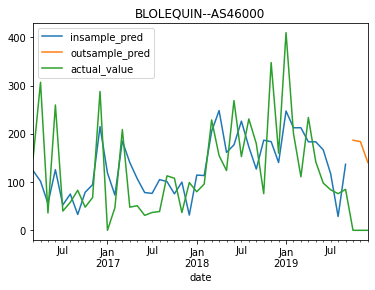

BOCANDA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=284.093, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=290.011, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=288.957, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=295.192, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=286.152, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=285.153, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=287.954, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=287.957, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=291.415, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.611 seconds
(0, 0, 0)
(0, 0, 0, 12)


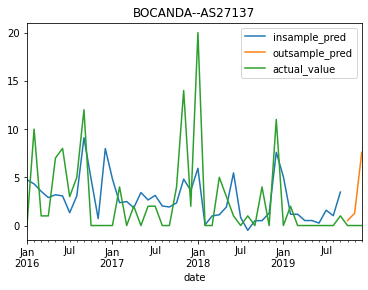

BOCANDA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=363.421, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=347.100, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=352.715, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=353.538, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=365.494, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=350.072, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=350.175, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=353.787, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=350.777, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=350.851, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=352.842, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.656 seconds
(0, 0, 0)
(0, 0, 0, 12)


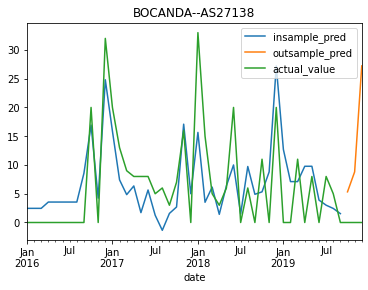

BONDOUKOU
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-775.994, Time=0.04 sec
Total fit time: 0.047 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
BONDOUKOU
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=167.635, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=174.592, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=174.583, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=176.799, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=170.956, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=170.946, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=171.235, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=171.236, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=174.687, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.669 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


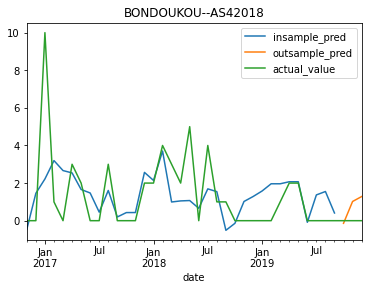

BONGOUANOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=202.835, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=180.726, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=187.843, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=187.793, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=179.895, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=184.070, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=184.045, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=187.913, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=184.444, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=184.424, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=188.223, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.471 seconds
(0, 0, 0)
(0, 0, 0, 12)


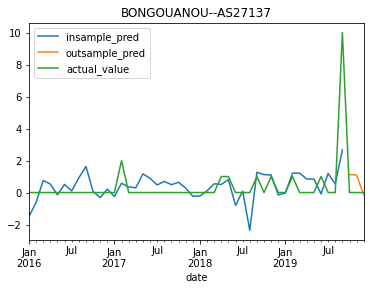

BONGOUANOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=312.842, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=315.864, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=316.136, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=325.698, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=315.522, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=315.477, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=312.809, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=315.952, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=316.634, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=316.491, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=312.754, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] i

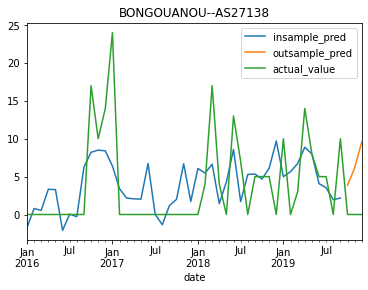

BOUAFLE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=467.271, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=474.227, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=474.315, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=474.156, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=471.116, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=471.102, Time=0.19 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=474.642, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=470.390, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=470.483, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=473.050, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 3.079 seconds
(0, 0, 0)
(0, 0, 0, 12)


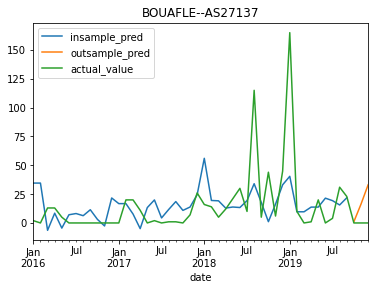

BOUAFLE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=551.590, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=539.138, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=544.002, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=544.623, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=547.714, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=542.199, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=541.884, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=545.252, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=540.599, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=541.601, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=540.061, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.584 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


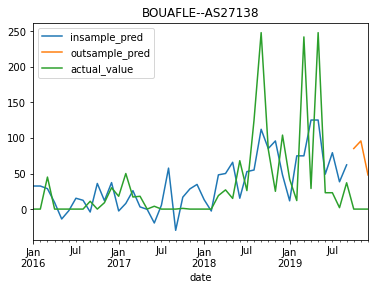

BOUAKE NORD-OUEST
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=192.762, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=173.527, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=228.713, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=170.270, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=173.527, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=173.245, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=173.359, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=185.072, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=175.463, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=168.507, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=171.754, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1

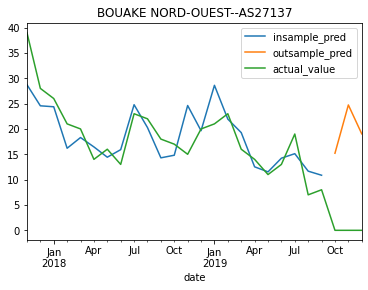

BOUAKE NORD-OUEST
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=189.697, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=187.598, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=192.017, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=221.831, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=185.364, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=187.945, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=189.254, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=186.056, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=187.425, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=189.002, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=183.981, Time=0.07 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : BIC=187.130, Time=0.25 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : BIC=187.163, Time=0.18 sec
 ARIMA(2,0,

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


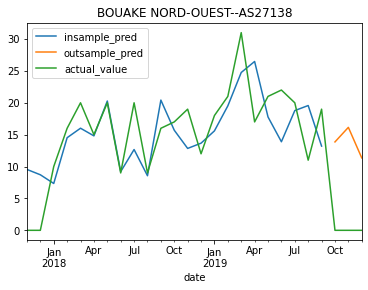

BOUNA
AS27137
BOUNA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=228.265, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=234.956, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=234.899, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=239.777, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=231.493, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=231.400, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=235.155, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=231.690, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=231.721, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=235.548, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.416 seconds
(0, 0, 0)
(0, 0, 0, 12)


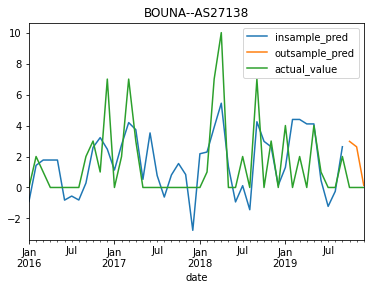

BOUNDIALI
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=375.380, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=358.308, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=364.358, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=402.510, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=355.542, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=357.724, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=358.324, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=356.255, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=362.485, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=359.463, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=356.260, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.169 seconds
(1, 0, 0)
(

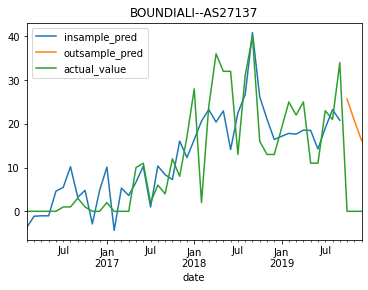

BOUNDIALI
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=316.487, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=320.486, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=307.333, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=315.954, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=338.511, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=303.691, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=307.289, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=303.141, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=306.179, Time=0.14 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=306.071, Time=0.12 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=309.679, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=306.113, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=306.274, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0

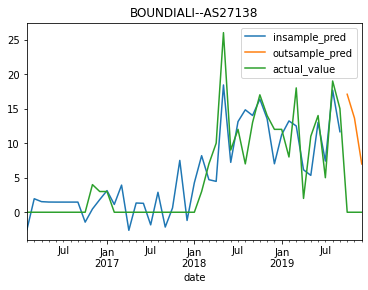

COCODY-BINGERVILLE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=428.459, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=413.991, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=424.350, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=458.099, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=410.908, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=413.838, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=407.300, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=410.255, Time=0.19 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=410.066, Time=0.17 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=411.005, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=410.860, Time=0.10 sec
 ARIMA(1,0,1)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


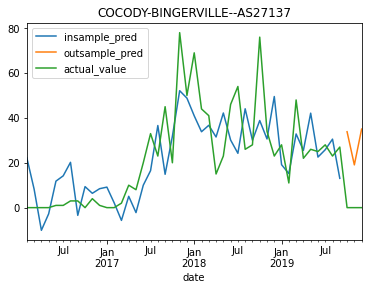

COCODY-BINGERVILLE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=462.908, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=429.679, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=442.135, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=495.593, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=425.826, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=429.682, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=429.128, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=428.832, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=438.809, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=432.565, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=424.968, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=428.737, Time=0.10 sec
 ARIMA(1,0,0)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


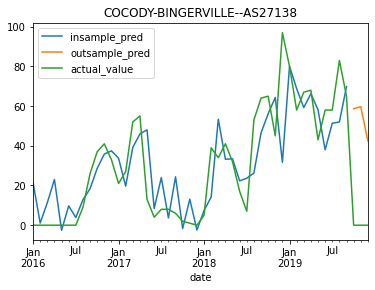

DABAKALA
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-309.273, Time=0.03 sec
Total fit time: 0.030 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
DABOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=399.139, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=405.341, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=405.247, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=433.721, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=402.757, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=402.804, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=401.612, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=401.504, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=404.579, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.509 seconds
(0, 0, 0)
(0, 0, 0, 12)


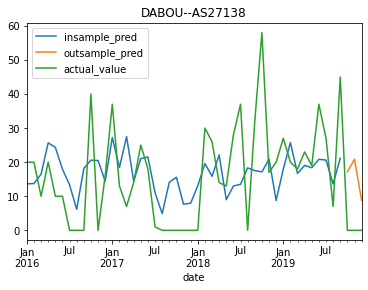

DABOU
AS27139
DALOA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=455.606, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=441.090, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=444.716, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=444.754, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=464.204, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=441.040, Time=0.13 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=444.911, Time=0.29 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=444.911, Time=0.22 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=441.222, Time=0.12 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=448.782, Time=0.48 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=444.779, Time=0.20 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=446.727, Time=0.49 sec
 ARIMA(0,0,0)(1,0,0)[12]             : BIC=466.737, Time=0.07 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 3.443 s

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


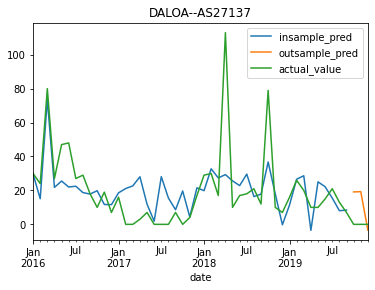

DALOA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=275.830, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=282.697, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=282.808, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=301.201, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=279.480, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=279.474, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=278.852, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=278.958, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=282.187, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.620 seconds
(0, 0, 0)
(0, 0, 0, 12)


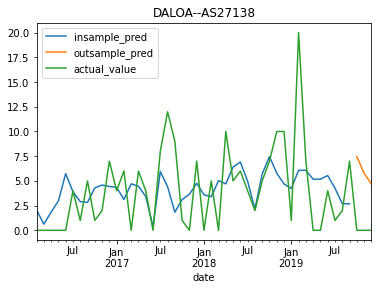

DANANE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=338.213, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=344.742, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=344.394, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=358.408, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=341.546, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=341.547, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=345.375, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=340.937, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=340.574, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=343.121, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.439 seconds
(0, 0, 0)
(0, 0, 0, 12)


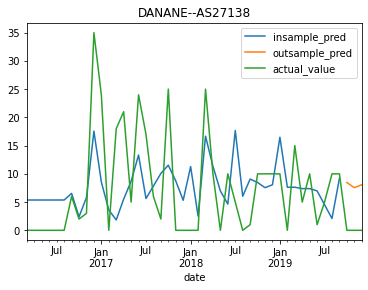

DANANE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=204.939, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=185.771, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=193.451, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=206.717, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=182.222, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=185.770, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=189.317, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=183.825, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=184.637, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=190.112, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=179.412, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=182.968, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12]  

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
DAOUKRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=328.022, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=332.233, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=332.252, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=347.435, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=331.648, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=331.476, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=328.877, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=329.063, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=330.041, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.802 seconds
(0, 0, 0)
(0, 0, 0, 12)


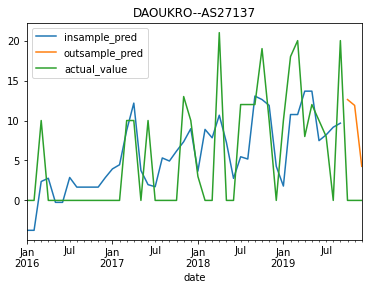

DAOUKRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=333.299, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=326.052, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=323.684, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=326.779, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=341.615, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=320.315, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=323.710, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=327.551, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=321.832, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=322.353, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=324.085, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=323.159, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=322.329, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.605 seconds
(1, 0

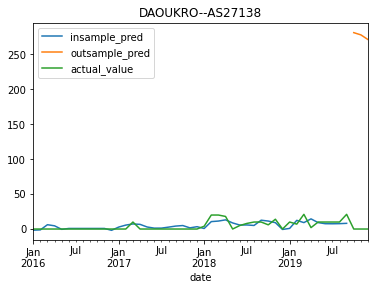

DIDIEVI
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=211.118, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=216.484, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=215.950, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=213.816, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=212.874, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=212.215, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=215.678, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=214.774, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=214.701, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.25 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.947 seconds
(0, 0, 0)
(0, 0, 0, 12)


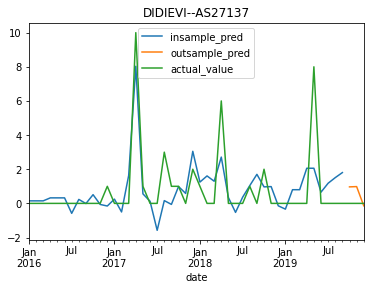

DIDIEVI
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=136.039, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=141.845, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=141.246, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=138.918, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=139.558, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=139.539, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=138.420, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=137.952, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.919 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


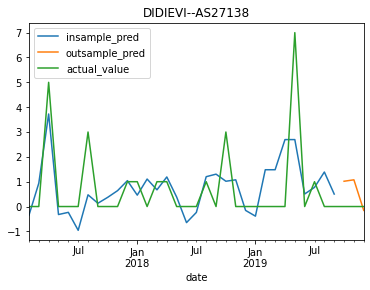

DIMBOKRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=249.805, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=249.821, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=235.874, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=241.515, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=279.792, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=232.348, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=235.879, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=239.358, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=235.850, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=235.843, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=239.961, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=239.326, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=232.136, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=235.516, Time=0.08 sec
 ARIMA(1,0,0)(0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


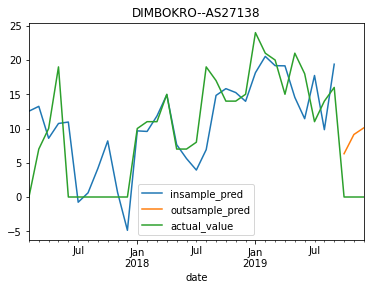

DIMBOKRO
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-879.788, Time=0.03 sec
Total fit time: 0.030 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


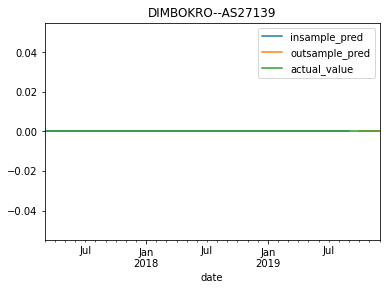

DIVO
AS42018
DIVO
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=301.153, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=303.869, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=299.940, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=300.907, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=304.059, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=304.030, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=307.117, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 2.262 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
DUEKOUE
AS46000
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-568.466, Time=0.03 sec
Total fit time: 0.035 seconds
(

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
FERKESSEDOUGOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=370.644, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=362.240, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=368.095, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=393.744, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=359.797, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=362.148, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=360.757, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=361.554, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=365.909, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=364.126, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=361.872, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.435 seconds


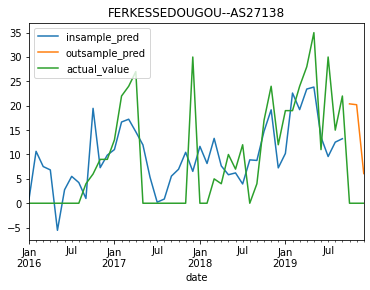

FERKESSEDOUGOU
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=325.302, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=299.031, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=311.793, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=328.976, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=295.240, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=299.033, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=302.765, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=298.470, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=298.438, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=308.024, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=302.240, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=292.761, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=296.565, Time=0.06 sec
 ARIMA(1,0,0)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


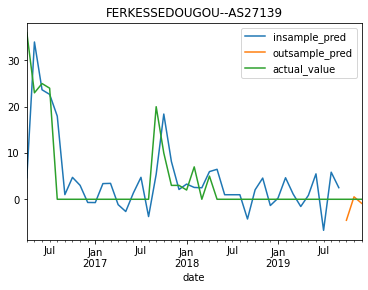

FRESCO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=112.546, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=92.644, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=98.227, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=97.979, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=90.266, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=96.454, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=96.452, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=100.310, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=94.381, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=94.137, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=97.988, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.418 seconds
(0, 0, 0)
(0, 0, 0, 12)


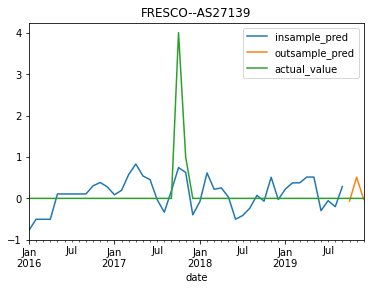

GAGNOA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=363.998, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=381.117, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=355.675, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=367.914, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=402.251, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=352.803, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=355.561, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=359.179, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=351.800, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=355.650, Time=0.23 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=355.650, Time=0.13 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=359.500, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=355.504, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=355.582, Time=0.09 sec
 ARIMA(1,0,1)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


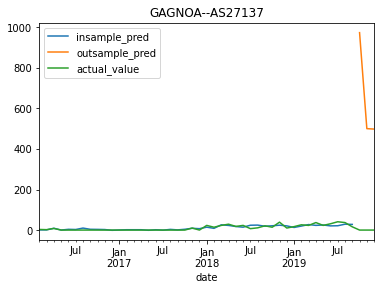

GAGNOA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=338.332, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=332.709, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=337.730, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=359.012, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=329.309, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=332.791, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=330.973, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=331.555, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=334.253, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=334.630, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=330.784, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.845 seconds
(1, 0, 0)
(0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


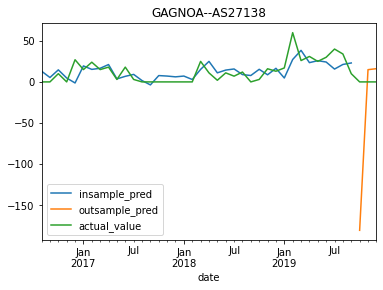

GRAND-BASSAM
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=376.187, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=344.069, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=407.431, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=340.337, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=343.996, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.54 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=344.203, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=344.189, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=339.529, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=342.969, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12]        

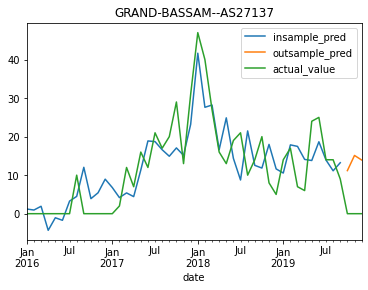

GRAND-BASSAM
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=438.902, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=444.232, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=433.826, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=442.647, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=458.687, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=430.205, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=433.746, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=437.289, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=426.709, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=430.540, Time=0.25 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=430.537, Time=0.17 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=434.352, Time=0.59 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=430.467, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=430.440, Time=0.08 sec
 ARIMA(1,0,1

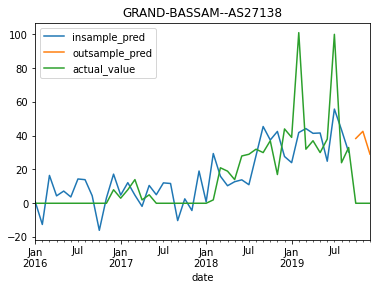

GRAND-LAHOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.31 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=348.901, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=350.964, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=351.405, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=363.341, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=350.911, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=349.178, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=348.141, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=350.437, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=347.746, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=350.730, Time=0.19 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=350.458, Time=0.15 sec
 ARIMA(2,0,0)(1,0,1)[12] 

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


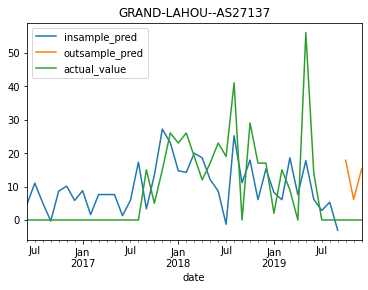

GRAND-LAHOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=311.948, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=288.872, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=301.984, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=316.906, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=285.124, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=288.878, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=288.800, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=288.838, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=298.360, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=291.274, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=282.618, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=286.379, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


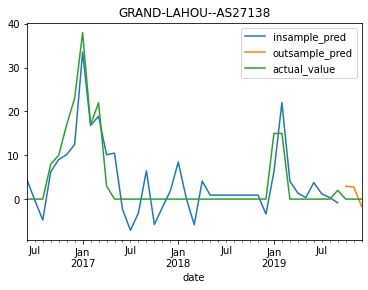

GUEYO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=325.609, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=324.026, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=324.215, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=345.522, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=322.317, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=324.164, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=325.889, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=325.543, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=323.670, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=329.388, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=326.124, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.804 seconds
(1, 0, 0)
(0, 0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


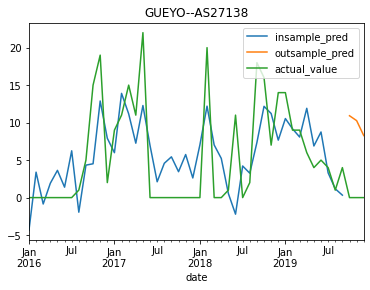

GUEYO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=229.237, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=236.907, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=236.912, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=228.053, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=233.071, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=233.059, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=233.069, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=233.087, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=235.534, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.452 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


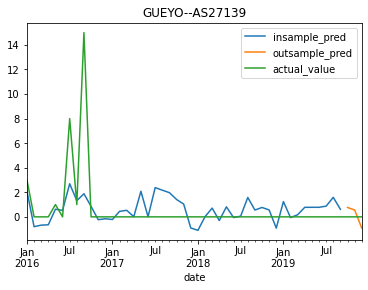

GUIGLO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=390.919, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=394.251, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=395.073, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=402.990, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=393.232, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=393.493, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=391.380, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=392.219, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=394.219, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.663 seconds
(0, 0, 0)
(0, 0, 0, 12)


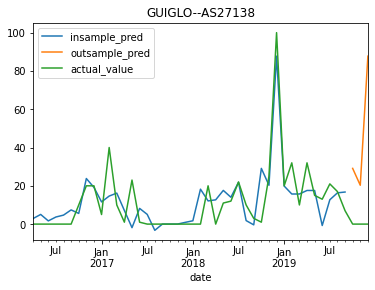

GUIGLO
AS46000
GUITRY
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=275.343, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=255.924, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=262.088, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=262.471, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=274.013, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=259.684, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=259.700, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=258.254, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=258.621, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=261.383, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.455 seconds
(0, 0, 0)
(0, 0, 0, 12)


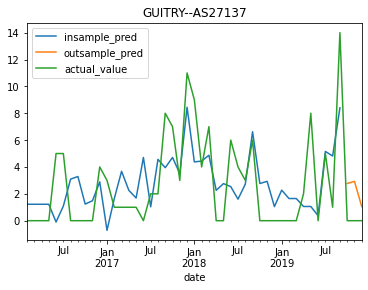

GUITRY
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=305.088, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=309.401, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=302.774, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=308.914, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=320.593, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=299.244, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=302.629, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=298.407, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=300.372, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=299.943, Time=0.12 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=303.610, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=301.032, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=299.745, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[1

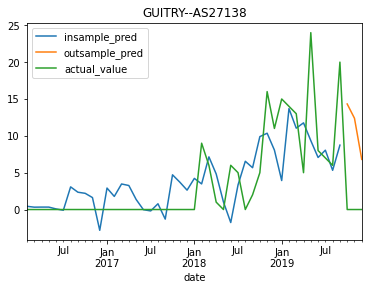

ISSIA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=424.939, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=411.080, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=417.641, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=469.705, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=408.103, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=410.448, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=410.733, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=410.948, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=416.011, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=414.438, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=411.581, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.893 seconds
(1, 0, 0)
(0, 0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


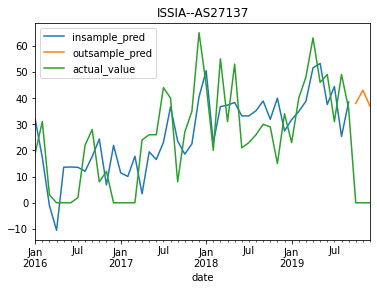

ISSIA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=396.882, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=405.659, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=390.376, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=395.523, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=425.515, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=388.355, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=390.395, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=394.175, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=389.802, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=388.264, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=390.160, Time=0.24 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=390.310, Time=0.18 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=393.989, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=393.994, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


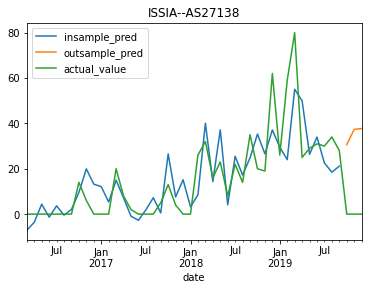

JACQUEVILLE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=346.760, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=352.997, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=352.682, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=348.980, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=349.319, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=348.982, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=350.506, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=350.506, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=353.642, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.263 seconds
(0, 0, 0)
(0, 0, 0, 12)


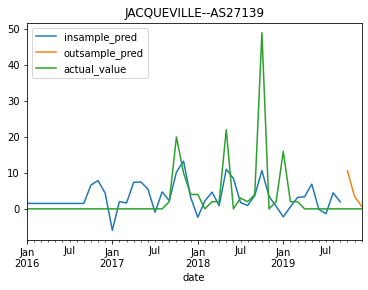

JACQUEVILLE
AS42018
KATIOLA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=382.257, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=363.158, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=363.776, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=408.862, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=359.422, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=363.167, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=361.030, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=359.459, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=359.906, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=363.176, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=360.368, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.709 s

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


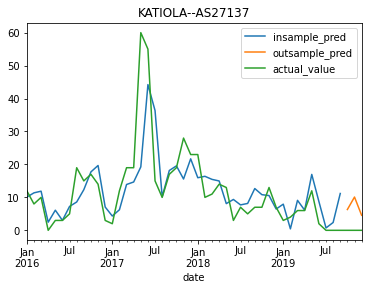

KATIOLA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=418.520, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=419.053, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=420.502, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=444.421, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=421.644, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=421.862, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=425.143, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=415.485, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=419.160, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=422.561, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=418.615, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=417.843, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=416.718, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


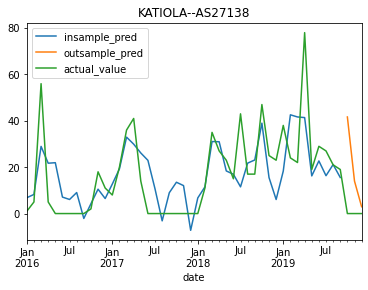

KORHOGO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=375.649, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=382.025, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=373.594, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=380.321, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=402.434, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=371.644, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=373.043, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=368.036, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=370.266, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=370.119, Time=0.13 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=373.907, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=369.414, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=371.116, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[

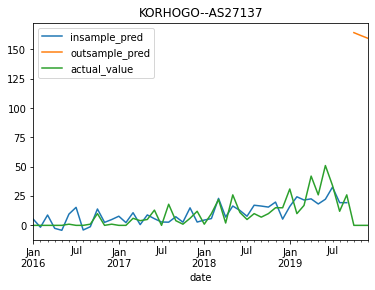

KORHOGO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=410.112, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=377.201, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=397.713, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=414.467, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=373.337, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=377.201, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=372.844, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=376.709, Time=0.14 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=376.708, Time=0.13 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=380.570, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=375.264, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=376.206, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


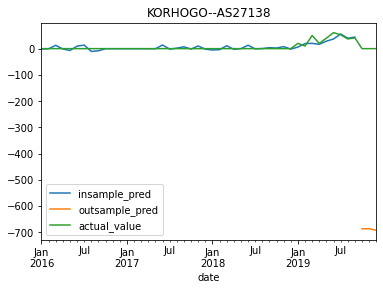

KORO
AS46000
KOUIBLY
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=364.860, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=339.228, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=353.389, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=379.994, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=335.805, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=339.409, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=339.248, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=339.407, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=351.053, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=340.287, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=334.359, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=338.182, Time=0.06 sec
 ARIMA(1,0,0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


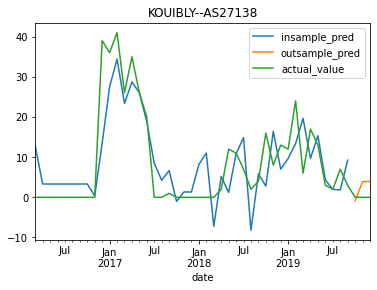

KOUIBLY
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-516.601, Time=0.02 sec
Total fit time: 0.021 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
KOUMASSI-PORT BOUET-VRIDI
AS27137
Performing stepwise search to minimize bic


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=498.675, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=504.324, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=503.321, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=524.954, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=502.464, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=502.457, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=506.329, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=500.490, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=499.582, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=502.813, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.873 seconds
(0, 0, 0)
(0, 0, 0, 12)


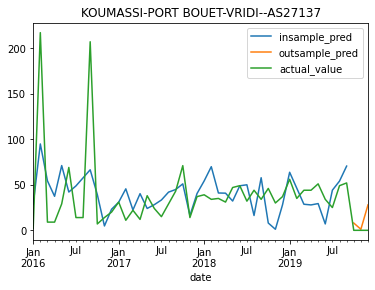

KOUMASSI-PORT BOUET-VRIDI
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=432.169, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=463.601, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=426.974, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=436.796, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=481.863, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=424.557, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=427.491, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=429.407, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=426.139, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=425.635, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=435.378, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=429.424, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=422.928, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=425.960, Time=0.05 sec

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


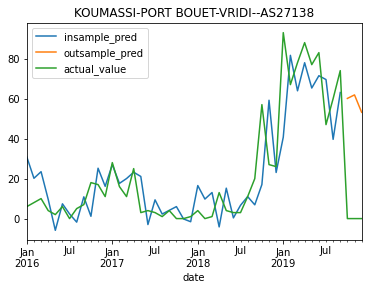

LAKOTA
AS27139
M'BAHIAKRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=157.046, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=163.521, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=163.610, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=164.864, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=160.300, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=160.286, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=160.416, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=160.469, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=162.554, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.406 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


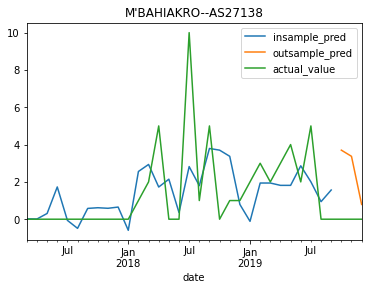

M'BAHIAKRO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=293.293, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=289.227, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=289.437, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=292.076, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=285.423, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=289.226, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=293.044, Time=0.51 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=288.605, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=288.616, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=285.680, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=282.480, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=286.308, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


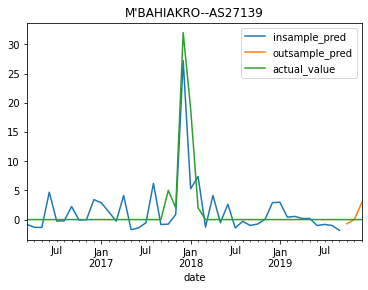

MAN
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-672.218, Time=0.02 sec
Total fit time: 0.021 seconds
(0, 0, 0)
(0, 0, 0, 0)
error


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MAN
AS42018
MANKONO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=352.629, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=343.885, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=341.067, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=341.225, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=363.733, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=341.057, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=340.791, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=344.600, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=344.591, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=348.316, Time=0.92 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=342.562, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=344.254, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=343.536, Time=0.21 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : BIC=347.364, Time=0.27 sec
 ARIM

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


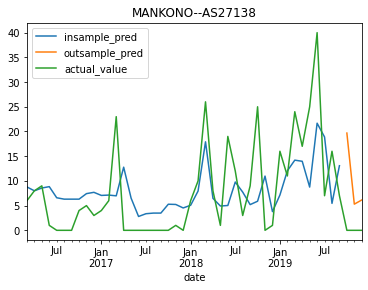

MANKONO
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-594.401, Time=0.02 sec
Total fit time: 0.022 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
MINIGNAN

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=232.605, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=238.993, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=238.913, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=233.215, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=235.822, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=235.834, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=235.681, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=235.592, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=238.607, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.425 seconds
(0, 0, 0)
(0, 0, 0, 12)


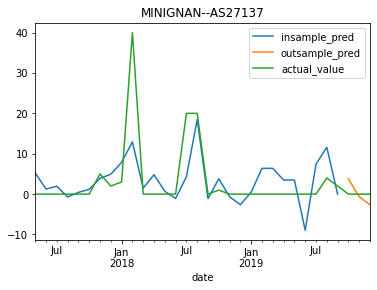

MINIGNAN
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=205.354, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=211.427, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=211.338, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=208.446, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=208.367, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=208.234, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=208.416, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=208.455, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=211.602, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.336 seconds
(0, 0, 0)
(0, 0, 0, 12)


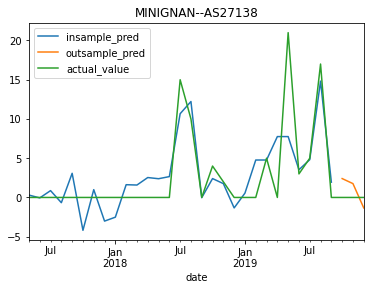

NASSIAN
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.02 sec
Total fit time: 0.021 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
NASSIAN
AS46000
NIAKARAMADOUGOU
AS27137
Performing stepwise search to minimize bic


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=333.811, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=331.840, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=335.150, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=363.097, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=328.713, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=331.533, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=330.266, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=329.212, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=331.748, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=333.078, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=333.495, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.810 seconds
(1, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


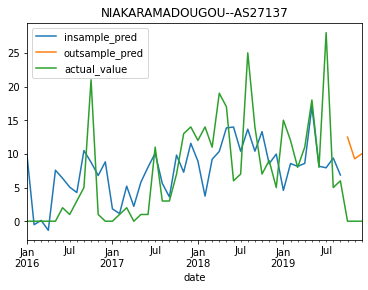

NIAKARAMADOUGOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=398.924, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=377.336, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=382.403, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=435.645, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=376.130, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=375.873, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=378.181, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=395.216, Time=0.07 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=379.464, Time=0.18 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=379.552, Time=0.14 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : BIC=382.505, Time=0.37 sec
 ARIMA(1,0,0)(0,0,1)[

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


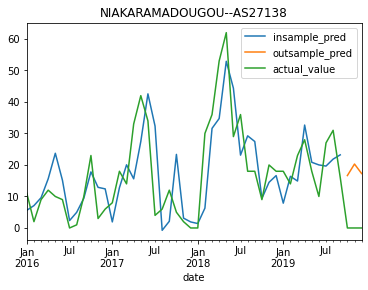

ODIENNE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=423.512, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=427.324, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=428.226, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=454.983, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=426.160, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=425.899, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=429.749, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=423.508, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=427.282, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=430.885, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=423.277, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=426.928, Time=0.20 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=426.752, Time=0.18 sec
 ARIMA(2,0,0)(1,0,1)[

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


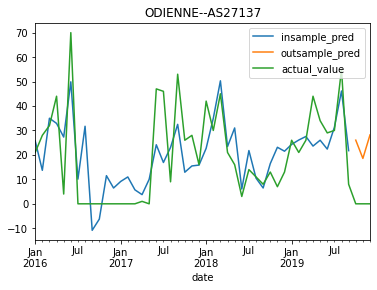

ODIENNE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=422.293, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=415.876, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=408.426, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=409.348, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=439.500, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=406.543, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=408.120, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=411.955, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=410.381, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=410.293, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=407.354, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=413.764, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=409.072, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.778 seconds
(1, 0

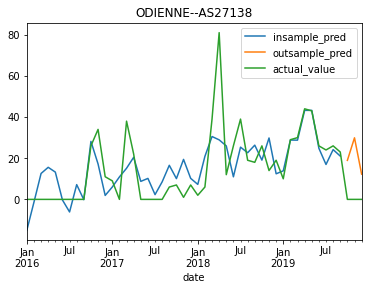

OUANGOLO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=314.205, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=313.266, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=313.058, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=340.959, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=316.020, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=314.899, Time=0.11 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=311.197, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=312.991, Time=0.08 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : B

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


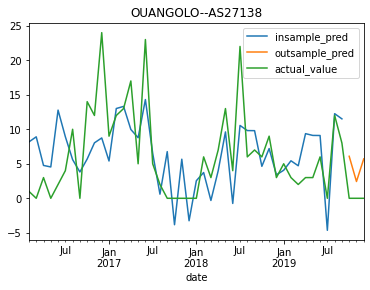

OUANGOLO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=285.388, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=291.338, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=290.967, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=285.418, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=287.507, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=287.168, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=291.000, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=289.176, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=289.191, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=292.700, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.246 seconds
(0, 0, 0)
(0, 0, 0, 12)


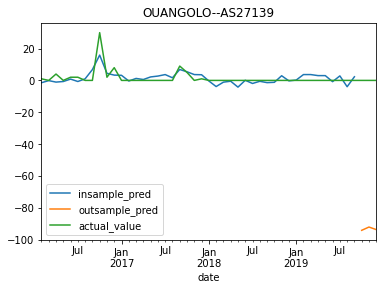

OUME
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=256.840, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=247.280, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=242.944, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=242.796, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=264.333, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=242.022, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=242.622, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=246.201, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=244.634, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=244.820, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=241.131, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=243.305, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=246.544, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=244.673, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)

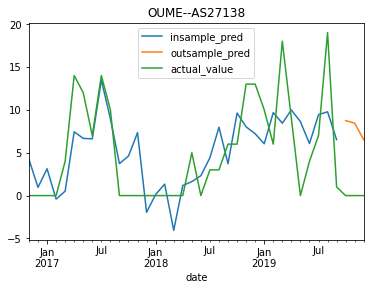

OUME
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=252.262, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=235.679, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=235.969, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=255.739, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=231.945, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=235.670, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=229.359, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=233.203, Time=0.09 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=233.202, Time=0.08 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=237.036, Time=0.36 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=233.021, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=233.116, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] int

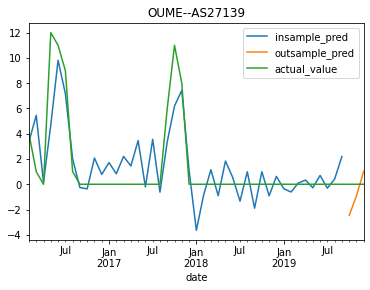

PRIKRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=337.275, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=344.482, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=344.291, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=366.066, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=341.076, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=341.043, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=340.788, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=340.728, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=343.972, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.554 seconds
(0, 0, 0)
(0, 0, 0, 12)


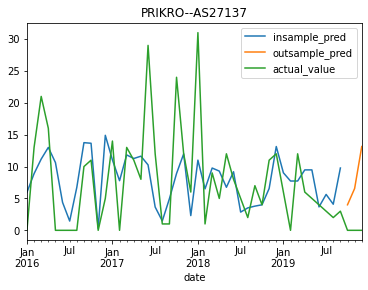

PRIKRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=219.375, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=226.292, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=226.123, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=224.913, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=223.075, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=223.020, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=226.675, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=222.596, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=222.493, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=226.339, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.461 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


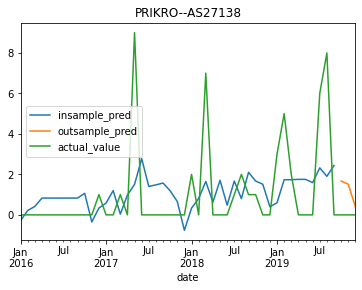

SAKASSOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=290.727, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=268.703, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=276.428, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=276.429, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=280.412, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=272.558, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=272.558, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=272.574, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=272.574, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=275.785, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.297 seconds
(0, 0, 0)
(0, 0, 0, 12)


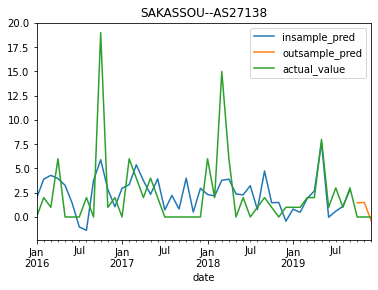

SAKASSOU
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=62.599, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=70.289, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=70.287, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=59.738, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=66.443, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=66.442, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=70.307, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=66.448, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=66.447, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.681 seconds
(0, 0, 0)
(0, 0, 0, 12)


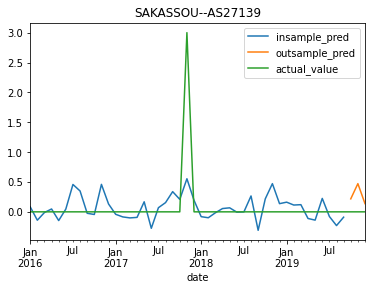

SAN PEDRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=395.319, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=400.274, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=399.324, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=403.764, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=397.719, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=397.095, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=397.969, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=397.389, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=395.144, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=398.024, Time=0.22 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=397.568, Time=0.23 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[12] in

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


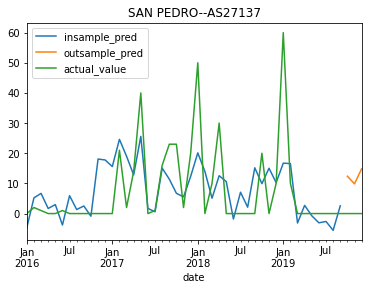

SAN PEDRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=125.814, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=132.174, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=109.593, Time=0.35 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : BIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=103.392, Time=0.47 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


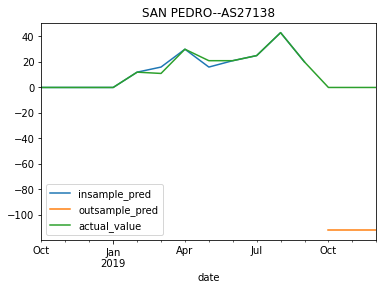

SASSANDRA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=248.092, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=253.576, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=253.623, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=265.109, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=251.764, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=251.658, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=250.467, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=250.784, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=253.389, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.536 seconds
(0, 0, 0)
(0, 0, 0, 12)


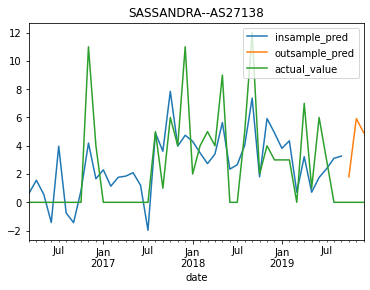

SASSANDRA
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-931.691, Time=0.02 sec
Total fit time: 0.023 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
SEGUELA

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=401.189, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=400.552, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=403.313, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=419.084, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=396.972, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=400.605, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=404.333, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=397.742, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=397.731, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=399.675, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=401.061, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=399.982, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.739 seconds
(1, 0, 0)
(0, 0,

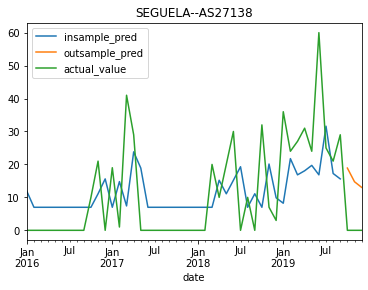

SEGUELA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=58.348, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=45.047, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=43.733, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=57.538, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=40.147, Time=0.05 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=43.730, Time=0.14 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=39.040, Time=0.04 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=42.704, Time=0.11 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=42.704, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=41.372, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=41.037, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : B

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
SIKENSI
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=264.495, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=260.799, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=258.895, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=265.826, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=255.085, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=258.911, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=258.680, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=258.663, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=256.947, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=261.414, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=254.146, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12]             : BIC=258.017, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


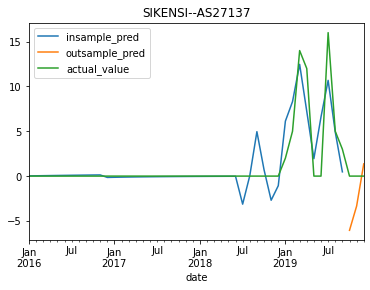

SIKENSI
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=267.409, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=270.680, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=272.699, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=269.472, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=271.095, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=270.850, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=266.864, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=270.658, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=257.377, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=261.241, Time=0.10 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=261.241, Time=0.09 sec
 ARIMA(2,0,0)(1,0,1)[12] inte

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


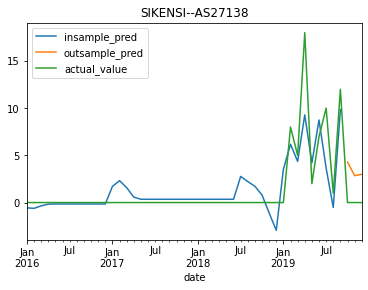

SINFRA
AS27139
SINFRA
AS42018
SOUBRE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=471.287, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=467.022, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=457.384, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=461.533, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=512.814, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=453.590, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=457.393, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=461.243, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=457.133, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=457.119, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=458.332, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=460.950, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=458.209, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


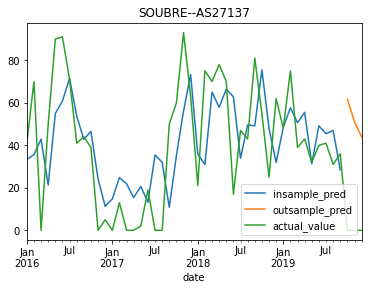

SOUBRE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=520.799, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=524.919, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=525.173, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=533.628, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=524.001, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=524.022, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=527.893, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=521.528, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=521.874, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=525.206, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.483 seconds
(0, 0, 0)
(0, 0, 0, 12)


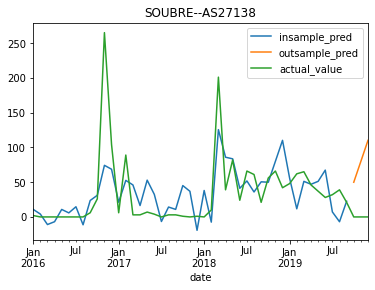

TABOU
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1243.161, Time=0.02 sec
Total fit time: 0.024 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


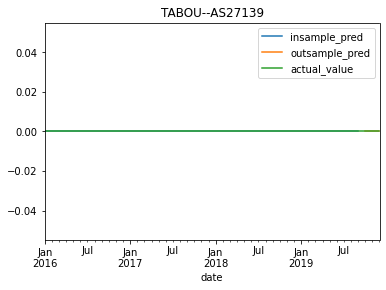

TABOU
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-698.160, Time=0.02 sec
Total fit time: 0.022 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
TANDA

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=288.566, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=273.808, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=280.972, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=280.946, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=278.493, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=277.277, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=277.211, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=277.509, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=277.548, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=281.011, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.547 seconds
(0, 0, 0)
(0, 0, 0, 12)


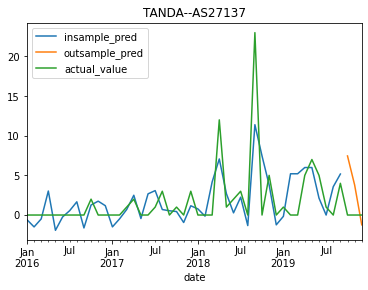

TANDA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=421.201, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=428.747, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=428.720, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=420.715, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=424.910, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=424.882, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=428.600, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=425.053, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=425.056, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=428.943, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.516 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


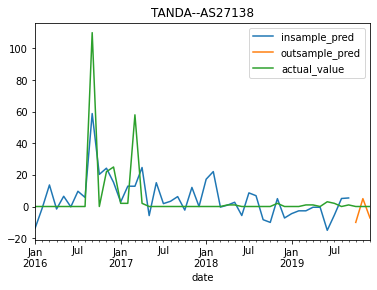

TENGRELA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=283.550, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=275.330, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=277.848, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=279.682, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=279.034, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=278.318, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=278.351, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=274.396, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=277.851, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=272.376, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=275.889, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=275.889, Time=0.13 sec
 ARIMA(2,0,0)(1,0,1)[12]

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


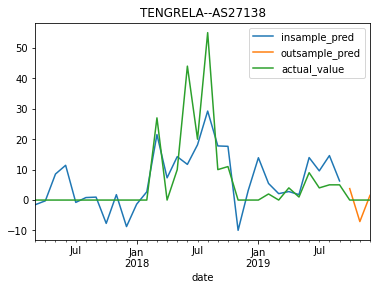

TENGRELA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=185.073, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=170.217, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=176.244, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=176.099, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=169.823, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=173.196, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=173.203, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=173.179, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=172.991, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=172.931, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.397 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
TIASSALE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


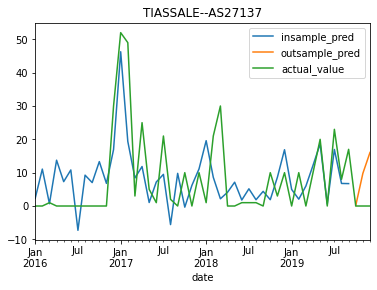

TIASSALE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=354.095, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=350.527, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=355.482, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=356.917, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=371.285, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=354.378, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=354.371, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=351.767, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=353.142, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=349.259, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=352.892, Time=0.26 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=352.871, Time=0.23 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[12]

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


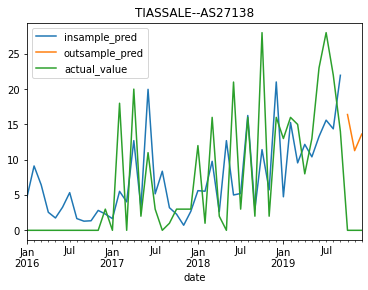

TIEBISSOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=211.258, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=196.359, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=197.820, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=198.400, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=212.727, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=196.904, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=198.024, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=198.897, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=195.570, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=198.299, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=200.800, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=199.239, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=198.442, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=195.978, Time=0.02 sec
 ARIMA(2,0,1)(0

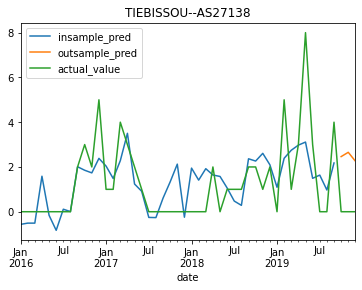

TIEBISSOU
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=180.132, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=182.136, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=184.097, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=182.028, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=182.926, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=182.765, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=186.387, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=178.531, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=182.114, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=177.240, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=181.047, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=181.044, Time=0.08 sec
 ARIMA(2,0,0)(1,0,1)[12

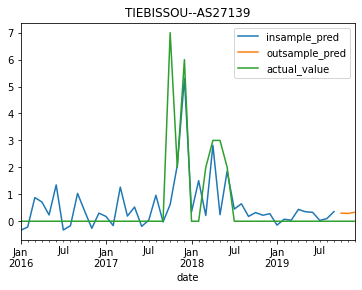

TOUBA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=299.889, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=305.838, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=293.512, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=301.075, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=336.609, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=289.680, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=293.514, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=297.351, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=291.174, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=292.152, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=297.816, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=294.791, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=292.246, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.440 seconds
(1, 0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


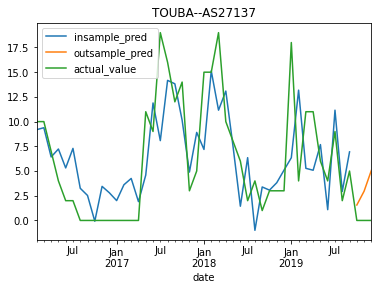

TOUBA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=404.940, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=410.127, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=410.550, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=414.539, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=406.830, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=407.259, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=407.622, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=407.870, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=410.886, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.918 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


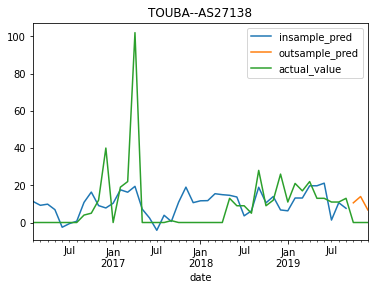

TOULEPLEU
AS27139
TOUMODI
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=228.811, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=232.975, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=232.332, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=251.089, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=229.398, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=228.801, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=232.277, Time=0.22 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=232.268, Time=0.18 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.76 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=232.299, Time=0.12 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=235.181, Time=0.36 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=nan, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 2.732 seconds

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


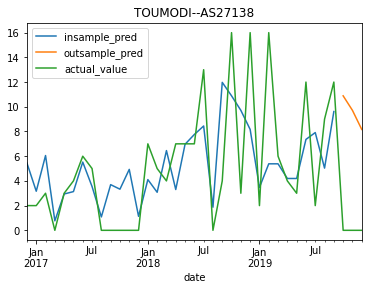

TOUMODI
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-983.596, Time=0.02 sec
Total fit time: 0.024 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


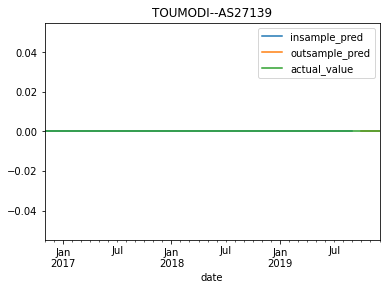

TREICHVILLE-MARCORY
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=317.200, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=324.167, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=323.833, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=340.405, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=320.875, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=320.843, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=320.518, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=320.230, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=323.359, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.659 seconds
(0, 0, 0)
(0, 0, 0, 12)


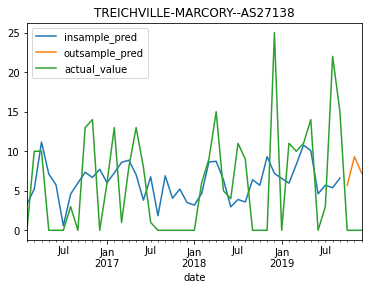

TREICHVILLE-MARCORY
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1191.244, Time=0.02 sec
Total fit time: 0.024 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


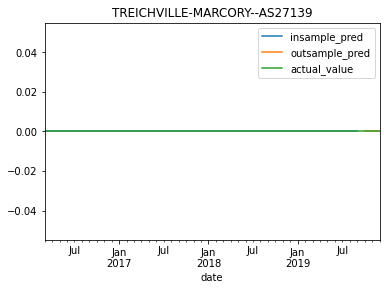

VAVOUA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=313.758, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=296.660, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=299.248, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=300.316, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=307.312, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=300.365, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=300.371, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=304.236, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=295.621, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=299.206, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=303.020, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=299.002, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=298.779, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=296.606, Time=0.03 sec
 ARIMA(2,0,1)(0,0,

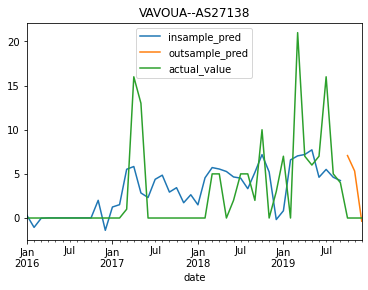

VAVOUA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=100.283, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=95.629, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=95.071, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=101.507, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=91.719, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=95.073, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=94.268, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=94.237, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=92.111, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=97.801, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=90.988, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12]             : BIC=94.571, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12]            

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


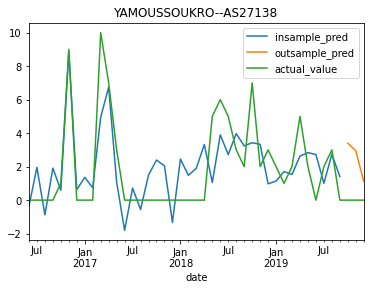

YAMOUSSOUKRO
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-879.788, Time=0.03 sec
Total fit time: 0.035 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
YOPOUGON-EST
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=364.069, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=367.682, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=368.658, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=398.678, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=367.316, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=366.779, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=370.521, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=363.871, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=367.617, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=371.315, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=364.193, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=363.863, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=367.734, Time=0.35 sec
 ARIMA(1,0

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


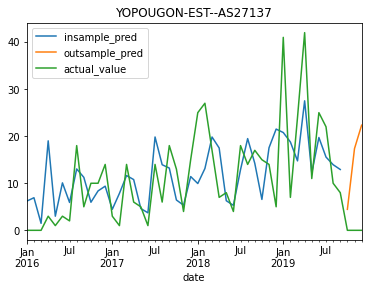

YOPOUGON-EST
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=415.173, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=419.027, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=420.250, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=436.235, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=416.700, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=417.711, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=416.372, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=417.270, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=417.754, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.859 seconds
(0, 0, 0)
(0, 0, 0, 12)


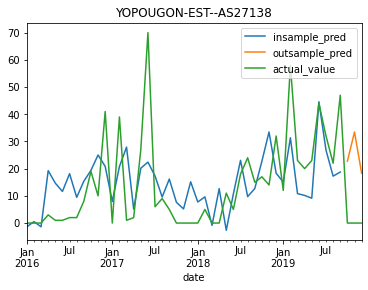

YOPOUGON-OUEST-SONGON
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=456.698, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=447.043, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=453.900, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=510.032, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=443.803, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=446.769, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=450.352, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=442.461, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=445.500, Time=0.25 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=444.812, Time=0.21 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=448.123, Time=0.50 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=440.958, Time=0.10 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : BIC=444.744, Time=0.42 sec
 ARIMA(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


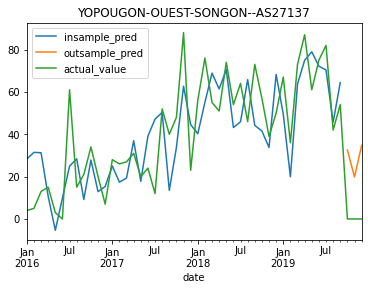

YOPOUGON-OUEST-SONGON
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=463.493, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=485.137, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=451.460, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=468.077, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=503.012, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=447.976, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=451.625, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=454.720, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=451.484, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=451.543, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=464.326, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=455.340, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=446.408, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=449.226, Time=0.07 sec
 AR

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


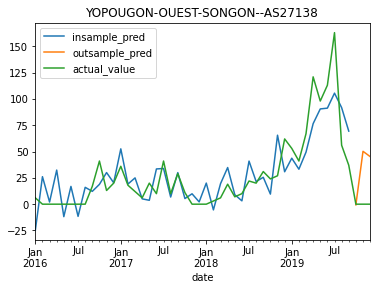

ZOUAN-HOUNIEN
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1191.244, Time=0.03 sec
Total fit time: 0.032 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


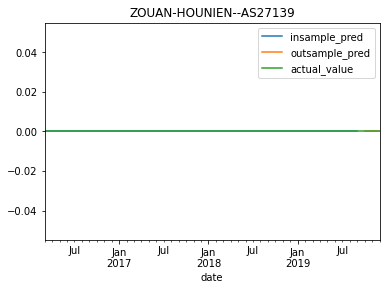

ZOUAN-HOUNIEN
AS42018
ZUENOULA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=286.704, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=282.737, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=298.362, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=287.005, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=284.270, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=285.034, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=283.129, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=283.772, Time=0.20 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=285.033, Time=0.10 sec
 ARIMA(2,0,1)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


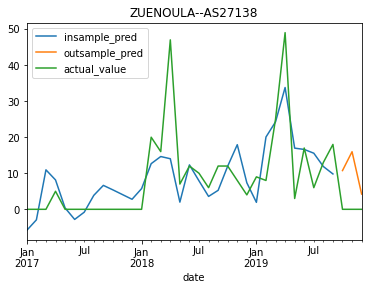

ZUENOULA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=423.379, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=418.195, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=416.390, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=431.311, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=413.175, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=416.396, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=420.173, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=418.035, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=416.734, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=414.706, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=419.528, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=415.685, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 1.530 seconds
(0, 0, 1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


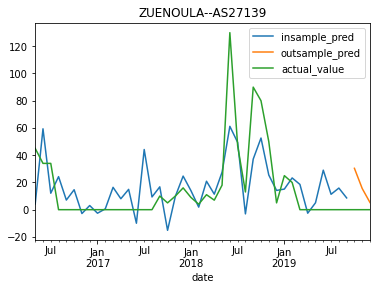

In [9]:
df_pred_district_product=pd.DataFrame()
for district in df_product_agg_level_sum['district'].unique() :
    df1=df_product_agg_level_sum[df_product_agg_level_sum['district']==district];
    for product in df1['product_code'].unique()[6:8]:
        df2=df1[df1['product_code']==product].copy();
        df2['date']=pd.to_datetime(df2['date']);
        df2=df2.set_index(['date']);
        df2=df2.resample('MS').fillna('nearest')
        print(district)
        print(product)
        #fit_and_plot_forecast(df2)
        if(len(df2)>10):
            [order,seasonal_order]=auto_arima(df2,col_exog); 
            #result_piece= fit_and_plot_sarimax(df2,order,seasonal_order,col_exog);
            result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=1);
            # print(result_piece)
            df_pred_district_product=pd.concat([df_pred_district_product,result_piece])
df_pred_district_product.to_csv('../2_pipeline/final_pred_district_lev.csv')

# Distribute 

In [30]:
contraceptive_logistics.tail(3)

date site_code product_code  year  month  stock_distributed  \
43603 2019-12-01     C3012      AS27134  2019     12                0.0   
42694 2019-12-01     C1701      AS27133  2019     12                0.0   
44503 2019-12-01     C5076      AS46000  2019     12                0.0   

                        region        district  regionroads  \
43603     PORO-TCHOLOGO-BAGOUE  FERKESSEDOUGOU   191.000000   
42694         AGNEBY-TIASSA-ME        TIASSALE    98.000000   
44503  KABADOUGOU-BAFING-FOLON            KORO    97.381154   

       regionasphaltroads  ...   pressure  relativehumidity  rainfallsnowmelt  \
43603           15.000000  ...  1011.5000          30.20000           0.00000   
42694           24.000000  ...   598.9047          78.26958          91.83673   
44503           12.278964  ...   598.9047          78.26958          91.83673   

       visibility  windspeed  maxsustainedwindspeed rainordrizzle     storm  \
43603    5.200000   6.600000              12.700000      0.000000  0.000000   
42694    8.567444   7.227927              14.248726      8.856819  8.747553   
44503    8.567444   7.227927              14.248726      8.856819  8.747553   

            fog  day  
43603  0.000000    1  
42694  1.313337    1  
44503  1.313337    1  

[3 rows x 30 columns]

In [31]:
contraceptive_logistics['group_sum']=contraceptive_logistics.groupby(['product_code','district','date'])['stock_distributed'].transform('sum') 
contraceptive_logistics['share']=contraceptive_logistics['stock_distributed']/contraceptive_logistics['group_sum'] 
y=contraceptive_logistics.share.fillna(0)
y.shape

(44504,)

In [32]:
from sklearn.preprocessing import OneHotEncoder


In [33]:
columns_to_encode=['site_code', 'product_code', 'year', 'month',
       'region', 'district', 'product_type','site_type'] # categorical 
columns_continuous=['regionroads',
       'regionasphaltroads', 'regionearthroads', 'regionsurfacetreatmentroads',
       'regionpoorroads', 'poorroads', 'earthroads', 'asphaltroads', 'temp',
       'maxtemp', 'pressure', 'relativehumidity', 'rainfallsnowmelt',
       'visibility', 'windspeed', 'maxsustainedwindspeed', 'rainordrizzle',
       'storm', 'fog'] # continuous 

ohe = OneHotEncoder(sparse=False,categories='auto')
encoded_columns =  ohe.fit_transform(contraceptive_logistics[columns_to_encode].fillna('NA'))

 

features=pd.DataFrame(data=encoded_columns,columns=ohe.get_feature_names(columns_to_encode))
features[columns_continuous]=contraceptive_logistics[columns_continuous]

In [34]:
X=features
X.shape

(44504, 313)

## Train Test Split

In [35]:
train_end

X.index

contraceptive_logistics.shape

contraceptive_logistics.set_index('date')[:train_end].shape[0]

train_length=contraceptive_logistics.set_index('date')[:train_end].shape[0]

X_train=X[:train_length]
y_train=y[:train_length]

## Random Forest Model

In [36]:
X_train.columns[X_train.isna().any()].tolist()

[]

In [37]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=30,n_estimators=10,random_state=21)
regr.fit(X_train , y_train)
y_pred=regr.predict(X)
 

In [38]:
len(y_pred)

44504

## Export Distribute District Level Result  ../2_pipeline/final_distribute_districtlev.csv'

In [39]:
distribute_districtlev=contraceptive_logistics[['date','district','site_code','product_code','stock_distributed']].copy()
distribute_districtlev['pred_share_districtlev']=y_pred 
distribute_districtlev['agg_level']='district'
col_export_distribute_agg=['date','district','site_code','product_code','pred_share_districtlev','agg_level']
distribute_districtlev[col_export_distribute_agg].to_csv('../2_pipeline/final_distribute_districtlev.csv')

In [40]:
len(distribute_districtlev)

44504

In [41]:
distribute_districtlev.head()

date      district site_code product_code  stock_distributed  \
14324 2016-01-01       SIKENSI     C1098      AS27137                0.0   
26460 2016-01-01     TIEBISSOU     C2068      AS46000                0.0   
11574 2016-01-01  GRAND-BASSAM     C1087      AS27000               50.0   
34391 2016-01-01         BOUNA     C4018      AS27139                0.0   
32742 2016-01-01     BONDOUKOU     C4002      AS27132                0.0   

       pred_share_districtlev agg_level  
14324                0.081555  district  
26460                0.073416  district  
11574                0.624580  district  
34391                0.000000  district  
32742                0.500000  district